# WAKE WORD MODEL TRAIN

## Imports

In [ ]:
!pip install lightning
!git clone https://github.com/Picovoice/wake-word-benchmark.git &> /dev/null
!wget https://groups.inf.ed.ac.uk/ami/AMICorpusMirror/amicorpus/TS3003a/audio/TS3003a.Mix-Headset.wav &> /dev/null
!wget http://www.openslr.org/resources/12/dev-clean.tar.gz
!tar -xzvf dev-clean.tar.gz


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 38.2 MB/s eta 0:00:00
--2025-01-26 10:25:27--  http://www.openslr.org/resources/12/dev-clean.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://openslr.elda.org/resources/12/dev-clean.tar.gz [following]
--2025-01-26 10:25:28--  http://openslr.elda.org/resources/12/dev-clean.tar.gz
Resolving openslr.elda.org (openslr.elda.org)... 141.94.109.138, 2001:41d0:203:ad8a::
Connecting to openslr.elda.org (openslr.elda.org)|141.94.109.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 337926286 (322M) [application

In [ ]:
import os
import tarfile
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import Dataset
import torch
import random
import numpy as np
import torchaudio as ta
import lightning.pytorch as pl
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import torchaudio
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from collections import Counter
import tempfile
import base64
from IPython.display import Javascript, display
from google.colab import output

In [ ]:
# Seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# link colab
from google.colab import drive
drive.mount('/content/drive')


cuda
Mounted at /content/drive


## Functions and classes

In [ ]:
# Dataset handling

class WakeWordDataset(Dataset):
    def __init__(self, pos_dir1, pos_dir2, neg_tar_path, neg_dir, segment_duration=3, sr=16000, augment=False, target_class_size=384):
        self.segment_length = segment_duration * sr
        self.sr = sr
        self.augment = augment
        self.data = []

        # Load positive samples more robustly
        jarvis_files = self._list_audio_files(pos_dir1)
        snowboy_files = self._list_audio_files(pos_dir2)

        # Balance datasets by downsampling the larger class
        min_class_size = min(len(jarvis_files), len(snowboy_files))
        jarvis_files = jarvis_files[:min_class_size]
        snowboy_files = snowboy_files[:min_class_size]

        # Add positive samples
        for file in jarvis_files:
            self.data.append((file, 1))  # Label 1 for "Jarvis"
        for file in snowboy_files:
            self.data.append((file, 2))  # Label 2 for "Snowboy"

        # Extract negative samples from the tar file
        neg_segments_1 = self._generate_negative_samples(neg_tar_path, int(target_class_size*0.75))
        neg_segments_2 = self._generate_negative_backgrounds(neg_dir, target_class_size-len(neg_segments_1))

        # Combining neg_segments_1 and neg_segments_2
        neg_segments = neg_segments_1 + neg_segments_2

        # Add negative samples (class 0)
        for segment in neg_segments:
            self.data.append((segment, 0))  # Label 0 for "No Wake Word"

        # Shuffle the data
        random.shuffle(self.data)

    def _list_audio_files(self, directory):
        audio_files = []
        for root, _, files in os.walk(directory):
            for file in files:
                if file.lower().endswith(('.wav', '.flac', '.mp3')):
                    audio_files.append(os.path.join(root, file))
        return audio_files

    def _extract_audio_files_from_tar(self, tar_path, extract_to='./tmp_audio'):
        # Extract the tar file content to a folder
        with tarfile.open(tar_path, 'r:gz') as tar:
            tar.extractall(path=extract_to)
        return extract_to

    def _generate_negative_samples(self, neg_tar_path, target_class_size):
        extract_path = self._extract_audio_files_from_tar(neg_tar_path)
        neg_files = self._list_audio_files(extract_path)

        # Limit to files that are 1-3 seconds long
        valid_files = []
        for neg_file in neg_files:
            audio, orig_sr = torchaudio.load(neg_file)
            duration = audio.size(1) / orig_sr  # COmpute length in seconds
            if 1 <= duration <= 3:
                valid_files.append(neg_file)

        # Randomly select the files
        selected_files = random.sample(valid_files, target_class_size)
        neg_segments = []
        segment_length = self.sr  # 1 second

        for neg_file in selected_files:
            audio, orig_sr = torchaudio.load(neg_file)
            if orig_sr != self.sr:
                audio = T.Resample(orig_sr, self.sr)(audio)

            # Ensure the audio is at least 1 second long
            if audio.size(1) >= segment_length:
                # Randomly select a start point for the 1-second segment
                start_idx = random.randint(0, audio.size(1) - segment_length)
                segment = audio[:, start_idx:start_idx + segment_length]
            else:
                # Pad the audio if it's shorter than 1 second
                segment = self._pad_or_trim(audio)

            # Normalize the segment
            segment = self._normalize_audio(segment)
            neg_segments.append(segment)

        print(f"Total negative segments: {len(neg_segments)}")
        return neg_segments

    def _generate_negative_backgrounds(self, neg_dir, target_class_size):
        audio, orig_sr = ta.load(neg_dir)
        if orig_sr != self.sr:
            audio = T.Resample(orig_sr, self.sr)(audio)

        # More comprehensive segmentation
        total_length = audio.size(1)
        segments = []
        hop_length = self.segment_length // 2  # Overlap segments

        max_segments = target_class_size  # How many windows we wnat to have

        # Get segments
        for start in range(0, total_length - self.segment_length + 1, hop_length):
            if len(segments) >= max_segments:
                break  # Stop when the desired number of windows has been reached
            segment = audio[:, start:start+self.segment_length]
            segments.append(segment)

        print(f"Total negative backgrounds: {len(segments)}")
        return segments

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        audio_or_path, label = self.data[idx]

        # Load audio
        if isinstance(audio_or_path, str):
            audio, sr = torchaudio.load(audio_or_path)
            if sr != self.sr:
                audio = T.Resample(sr, self.sr)(audio)
        else:
            audio = audio_or_path

        # Consistent length
        audio = self._pad_or_trim(audio)

        # Apply advanced augmentation if specified
        if self.augment:
            audio = self._advanced_augmentation(audio)

        return audio, label

    def _normalize_audio(self, audio):
        # Normalize audio to have values in the range [-1, 1].
        max_val = audio.abs().max()
        if max_val > 0:
            audio = audio / max_val
        return audio

    def _pad_or_trim(self, audio):
        if audio.size(1) > self.segment_length:
            # If too long, crop it!
            start_idx = (audio.size(1) - self.segment_length) // 2
            audio = audio[:, start_idx:start_idx + self.segment_length]
        elif audio.size(1) < self.segment_length:
            # If too short, pad it!
            pad_length = self.segment_length - audio.size(1)
            pad_before = pad_length // 2
            pad_after = pad_length - pad_before
            audio = F.pad(audio, (pad_before, pad_after), mode='constant', value=0)

        # Normalize it!
        audio = self._normalize_audio(audio)
        return audio


    def _advanced_augmentation(self, audio):
        # Gaussian noise
        noise = torch.randn_like(audio) * 0.01
        audio = audio + noise

        return audio.clamp(-1.0, 1.0)


In [ ]:
# Model

class WakeWordModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        # Mel Spectrogram transformation
        self.mel_spectrogram = T.MelSpectrogram(
            sample_rate=16000,
            n_fft=400,
            hop_length=160,
            n_mels=64,
            power=2.0
        )

        # Feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 37, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # Convert to mel spectrogram
        x = self.mel_spectrogram(x)

        # Extract features
        x = self.features(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Classify
        x = self.classifier(x)
        return x


In [ ]:
# Training function

def train_wake_word_model(train_loader, val_loader, epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = WakeWordModel().to(device)

    # Optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=5e-5,
        weight_decay=1e-4
    )

    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=3,
        verbose=True
    )

    # Loss function with class weights
    class_weights = torch.tensor([1.0, 2.0, 2.0]).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Training loop
    train_losses, val_losses = [], []
    val_accuracies = []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        # Training phase
        for i, (audio, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
            audio, labels = audio.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(audio)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()

            # Validate every 5 iterations
            if (i + 1) % 5 == 0:
                model.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for audio, labels in val_loader:
                        audio, labels = audio.to(device), labels.to(device)
                        outputs = model(audio)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                val_accuracy = 100 * correct / total
                val_accuracies.append(val_accuracy)
                model.train()

        # Validation phase at end of epoch
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for audio, labels in val_loader:
                audio, labels = audio.to(device), labels.to(device)
                outputs = model(audio)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Print epoch summary
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {100 * correct / total:.2f}%")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), '/content/drive/MyDrive/machine learning/ICT/PROJECT ICT PPPP/audio_model.pth')
            count = 0
        else:
            count += 1

        if count == 3:
            print("Early stopping triggered!")
            break

    # Plot the losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    return model


In [ ]:
# Testing function
def test_model(model, test_loader, class_names):

    class_weights = torch.tensor([1.0, 2.0, 2.0]).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    # Iterate over the test data
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # Store predictions and labels for confusion matrix
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Compute final loss and accuracy
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)

    print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    plt.figure(figsize=(10, 8))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=plt.gca())
    plt.title("Confusion Matrix")
    plt.show()

    # Compute F1-score
    f1 = f1_score(all_labels, all_preds, average=None)  # F1-score per classe
    avg_f1 = f1_score(all_labels, all_preds, average="weighted")  # Weighted average F1-score

    # Print F1-scores
    print("\nF1 Scores per class:")
    for i, score in enumerate(f1):
        print(f"  {class_names[i]}: {score:.4f}")
    print(f"\nWeighted Average F1 Score: {avg_f1:.4f}")


## Train and test

In [ ]:
# Directories and file paths
pos_dir1 = "./wake-word-benchmark/audio/jarvis"
pos_dir2 = "./wake-word-benchmark/audio/snowboy"
neg_file_1 = "./dev-clean.tar.gz"
neg_file_2 = "./TS3003a.Mix-Headset.wav"

# Create dataset
full_dataset = WakeWordDataset(pos_dir1, pos_dir2, neg_file_1, neg_file_2, segment_duration=3, augment=True)

# Counts the labels
label_counter = Counter()

# Iterate over the entire dataset
for audio, label in full_dataset:
    label_counter[label] += 1

# Print the results to check
print(label_counter)


Total negative segments: 288
Total negative backgrounds: 96
Counter({0: 384, 2: 384, 1: 384})


In [ ]:
# Train/Validation/Test sets split
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1*train_size)
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
train_dataset, val_dataset = random_split(train_dataset, [train_size-val_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Print the results to check
print(f"Training data: {len(train_dataset)} samples")
print(f"Validation data: {len(val_dataset)} samples")
print(f"Testing data: {len(test_dataset)} samples")

Training data: 829 samples
Validation data: 92 samples
Testing data: 231 samples


Epoch 1/10: 100%|██████████| 13/13 [00:11<00:00,  1.11it/s]


Epoch [1/10] Train Loss: 0.6699, Val Loss: 0.5056, Val Accuracy: 86.96%


Epoch 2/10: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch [2/10] Train Loss: 0.3615, Val Loss: 0.3824, Val Accuracy: 88.04%


Epoch 3/10: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Epoch [3/10] Train Loss: 0.2503, Val Loss: 0.4190, Val Accuracy: 89.13%


Epoch 4/10: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]


Epoch [4/10] Train Loss: 0.1805, Val Loss: 0.3718, Val Accuracy: 90.22%


Epoch 5/10: 100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


Epoch [5/10] Train Loss: 0.1309, Val Loss: 0.3274, Val Accuracy: 88.04%


Epoch 6/10: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch [6/10] Train Loss: 0.0918, Val Loss: 0.3394, Val Accuracy: 90.22%


Epoch 7/10: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


Epoch [7/10] Train Loss: 0.0747, Val Loss: 0.2567, Val Accuracy: 93.48%


Epoch 8/10: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s]


Epoch [8/10] Train Loss: 0.0542, Val Loss: 0.2668, Val Accuracy: 94.57%


Epoch 9/10: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


Epoch [9/10] Train Loss: 0.0472, Val Loss: 0.2625, Val Accuracy: 92.39%


Epoch 10/10: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch [10/10] Train Loss: 0.0271, Val Loss: 0.3295, Val Accuracy: 91.30%
Early stopping triggered!


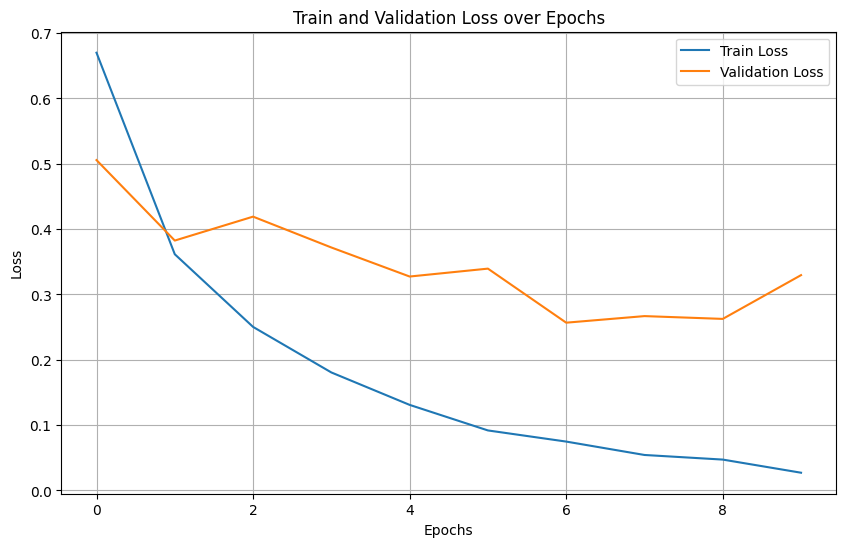

In [ ]:
# Train the model
model = train_wake_word_model(train_loader, val_loader, epochs=10)

Test Loss: 0.2241 Acc: 0.9307


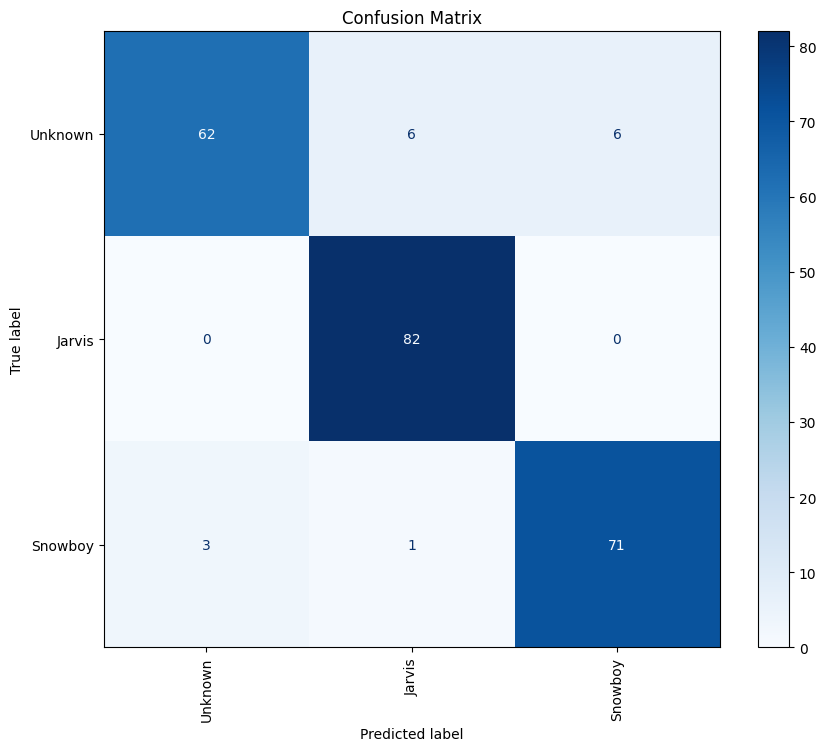


F1 Scores per class:
  Unknown: 0.8921
  Jarvis: 0.9591
  Snowboy: 0.9342

Weighted Average F1 Score: 0.9295


In [ ]:
# Test the model
test_model(model, test_loader, ['Unknown', 'Jarvis', 'Snowboy'])

## IRL Test of the model

In [ ]:
def record_audio(seconds=3):
    """
    Record audio directly in Google Colab.
    Args:
        seconds (int): Recording duration in seconds
    Returns:
        bytes: Raw audio data in bytes
    """
    RECORD = """
    const sleep = time => new Promise(resolve => setTimeout(resolve, time))
    const b2text = blob => new Promise(resolve => {
        const reader = new FileReader()
        reader.onloadend = e => resolve(e.srcElement.result)
        reader.readAsDataURL(blob)
    })
    var record = time => new Promise(async resolve => {
        stream = await navigator.mediaDevices.getUserMedia({ audio: true })
        recorder = new MediaRecorder(stream, { sampleRate: 16000 })
        chunks = []
        recorder.ondataavailable = e => chunks.push(e.data)
        recorder.start()
        await sleep(time)
        recorder.onstop = async ()=>{
            blob = new Blob(chunks)
            text = await b2text(blob)
            resolve(text)
        }
        recorder.stop()
    })
    """
    print("Recording... Speak now!")
    display(Javascript(RECORD))
    seconds += 1
    audio_data = output.eval_js('record(%d)' % (seconds * 1000))
    print("Recording complete!")
    return base64.b64decode(audio_data.split(',')[1])

def apply_noise_gate(waveform, threshold_db=-40):
    """
    Apply a noise gate to remove low volume sounds.
    Args:
        waveform (torch.Tensor): Input audio waveform
        threshold_db (float): Threshold in decibels below which audio will be silenced
    Returns:
        torch.Tensor: Processed waveform with noise gate applied
    """
    # Convert threshold from dB to amplitude
    threshold_amplitude = 10 ** (threshold_db / 20)

    # Calculate amplitude envelope
    window_size = 1024
    hop_length = 512
    envelope = torch.zeros_like(waveform)

    for i in range(0, waveform.size(1), hop_length):
        window = waveform[:, i:min(i + window_size, waveform.size(1))]
        envelope[:, i:i + window.size(1)] = torch.max(window.abs())

    # Create mask for samples above threshold
    mask = (envelope > threshold_amplitude).float()

    # Apply smooth fade to avoid clicks
    fade_samples = 128
    mask = F.pad(mask, (fade_samples, fade_samples))
    mask = F.avg_pool1d(mask, kernel_size=fade_samples*2 + 1, stride=1, padding=0)
    mask = mask[:, :waveform.size(1)]

    return waveform * mask

def _advanced_augmentation(audio):
    """
    Perform Gaussian noise augmentation.
    Args:
        audio (torch.Tensor): Input audio waveform (1 x N).
    Returns:
        torch.Tensor: Augmented audio waveform.
    """
    # Gaussian noise
    noise = torch.randn_like(audio) * 0.01
    audio = audio + noise

    return audio.clamp(-1.0, 1.0)

def center_audio(waveform, target_length, threshold_amplitude=0.15, sample_rate=16000):
    """
    Centers the audio around the region where the amplitude exceeds the threshold.
    It includes the region from the first sample that exceeds the threshold
    to the last sample that exceeds the threshold.

    Args:
        waveform (torch.Tensor): Input audio waveform (1 x N).
        target_length (int): Target length of the waveform (in samples).
        threshold_amplitude (float): Threshold for detecting amplitude peaks.
        sample_rate (int): Sample rate of the waveform (default 16 kHz).

    Returns:
        torch.Tensor: Centered waveform of target length.
    """
    # Find the indices of all samples where the amplitude exceeds the threshold
    exceed_idx = (waveform.abs() > threshold_amplitude).nonzero()

    if exceed_idx.size(0) == 0:
        raise ValueError("No samples exceed the threshold amplitude.")

    # Get the first and last index where the threshold is exceeded
    start_idx = exceed_idx[0, 1].item()  # First index
    end_idx = exceed_idx[-1, 1].item()   # Last index

    print(f"Start index: {start_idx}, End index: {end_idx}")

    # Define the segment that includes both the start and end indices
    audio_segment = waveform[:, start_idx:end_idx]

    # If the extracted segment is shorter than the target length, pad it
    if audio_segment.size(1) < target_length:
        pad_size = target_length - audio_segment.size(1)
        padding_left = pad_size // 2
        padding_right = pad_size - padding_left
        centered_waveform = F.pad(audio_segment, (padding_left, padding_right), "constant", 0)
    else:
        # If the extracted segment is longer, crop it to the target length
        start_crop = (audio_segment.size(1) - target_length) // 2
        centered_waveform = audio_segment[:, start_crop:start_crop + target_length]

    return centered_waveform


def process_audio(audio_bytes, target_sr=16000):
    """
    Process recorded audio to match model requirements with noise filtering,
    centering around highest volume, and applying advanced augmentations.
    Args:
        audio_bytes (bytes): Raw audio data.
        target_sr (int): Target sample rate.
    Returns:
        torch.Tensor: Processed and augmented audio tensor ready for model input.
    """
    with tempfile.NamedTemporaryFile(suffix='.wav', delete=True) as temp_file:
        temp_file.write(audio_bytes)
        temp_file.flush()

        waveform, sample_rate = torchaudio.load(temp_file.name)
        if sample_rate != target_sr:
            resampler = torchaudio.transforms.Resample(sample_rate, target_sr)
            waveform = resampler(waveform)

        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        waveform = apply_noise_gate(waveform)
        waveform = waveform / (waveform.abs().max() + 1e-8)

        target_length = target_sr * 3  # 3 seconds
        waveform = center_audio(waveform, target_length)

        time_axis = np.linspace(0, waveform.size(1) / target_sr, waveform.size(1))
        plt.figure(figsize=(10, 4))
        plt.plot(time_axis, waveform[0].numpy())
        plt.title("Processed and Augmented Audio")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")
        plt.grid()
        plt.show()

        return waveform.unsqueeze(0)

def test_wake_word(model, device, class_labels=['No Wake Word', 'Jarvis', 'Snowboy']):
    """
    Record and test audio for wake word detection. Plot the probs and the processed audio to check.
    """
    model.eval()

    # Record audio
    audio_bytes = record_audio(3)  # Record for 3 seconds

    # Process audio
    waveform = process_audio(audio_bytes)
    waveform = waveform.to(device)

    # Make prediction
    with torch.no_grad():
        output = model(waveform)
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities)

        # Print results
        print("\nDetection Results:")
        print("-" * 20)
        print("Probabilities:")
        for i, prob in enumerate(probabilities[0]):
            print(f"{class_labels[i]}: {prob.item()*100:.2f}%")

        print(f"\nFinal Prediction: {class_labels[predicted_class.item()]}")

    return predicted_class.item(), probabilities[0]


Recording... Speak now!


<IPython.core.display.Javascript object>

Recording complete!
Start index: 14163, End index: 23966


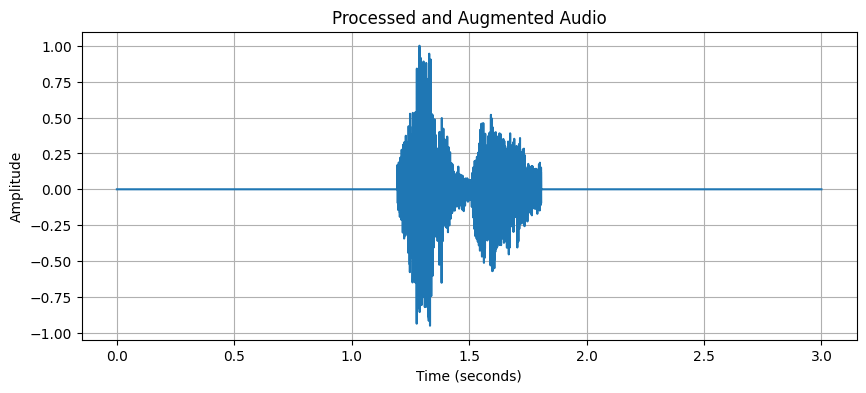


Detection Results:
--------------------
Probabilities:
No Wake Word: 41.12%
Jarvis: 58.88%
Snowboy: 0.00%

Final Prediction: Jarvis


In [ ]:
result, probs = test_wake_word(model, device)